Problem statement: To build a CNN based model which can accurately detect melanoma. Melanoma is a type of cancer that can be deadly if not detected early. It accounts for 75% of skin cancer deaths. A solution which can evaluate images and alert the dermatologists about the presence of melanoma has the potential to reduce a lot of manual effort needed in diagnosis.

### Importing Skin Cancer Data
#### To do: Take necessary actions to read the data

### Importing all the important libraries

In [1]:
# Importing libraries
from glob import glob
import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import os
import PIL
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import preprocessing
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D

In [2]:
## If you are using the data by mounting the google drive, use the following :
from google.colab import drive
drive.mount('/content/gdrive')

##Ref:https://towardsdatascience.com/downloading-datasets-into-google-drive-via-google-colab-bcb1b30b0166

Mounted at /content/gdrive


This assignment uses a dataset of about 2357 images of skin cancer types. The dataset contains 9 sub-directories in each train and test subdirectories. The 9 sub-directories contains the images of 9 skin cancer types respectively.

In [3]:
# Path libraries
path_to_train_directory = "/content/gdrive/MyDrive/app/data/Train"
path_to_test_directory = "/content/gdrive/MyDrive/app/data/Test"
base_path = "/content/gdrive/MyDrive/app/data"

In [4]:
# Defining the path for train and test images
## Todo: Update the paths of the train and test dataset
data_dir_train = pathlib.Path(path_to_train_directory)
data_dir_test = pathlib.Path(path_to_test_directory)
data_dir = pathlib.Path(base_path)

In [5]:
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print(image_count_train)
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print(image_count_test)

2251
118


### Load using keras.preprocessing

Let's load these images off disk using the helpful image_dataset_from_directory utility.

### Create a dataset

Define some parameters for the loader:

In [6]:
batch_size = 32
img_height = 180
img_width = 180

Use 80% of the images for training, and 20% for validation.

In [7]:
## Write your train dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
train_ds  = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir_train,
    seed=123,
    validation_split=0.2,
    subset = 'training',
    image_size=(img_height, img_width),
    batch_size=batch_size
)

Found 2251 files belonging to 9 classes.
Using 1801 files for training.


In [8]:
## Write your validation dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir_train,
    seed=123,
    validation_split=0.2,
    subset='validation',
    image_size=(img_height, img_width),
    batch_size=batch_size
)

Found 2251 files belonging to 9 classes.
Using 450 files for validation.


In [9]:
# List out all the classes of skin cancer and store them in a list. 
# You can find the class names in the class_names attribute on these datasets. 
# These correspond to the directory names in alphabetical order.
class_names = train_ds.class_names
print(class_names)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign', 'seborrheic keratosis', 'squamous cell', 'vascular lesion']


In [10]:
# Finding all the class names for the image classification task
CLASS_NAMES = np.array([item.name for item in data_dir.glob('Train/*')])
np.array([item.name for item in data_dir.glob('Train/*')])

array(['seborrheic keratosis', 'melanoma', 'vascular lesion',
       'dermatofibroma', 'basal cell carcinoma', 'actinic keratosis',
       'nevus', 'pigmented benign', 'squamous cell'], dtype='<U20')

### Visualize the data
#### Todo, create a code to visualize one instance of all the nine classes present in the dataset

In [11]:
# Image Rescaling. The 1./255 is to convert from unit8 to float32 in range[0, 1]
image_generator = keras.preprocessing.image.ImageDataGenerator(rescale=1./255)

train_data_gen = image_generator.flow_from_directory(directory=data_dir_train,
                                                    batch_size=batch_size,
                                                    shuffle=True,
                                                    target_size=(img_height, img_width),
                                                    classes=list(CLASS_NAMES),
                                                    class_mode='categorical')

Found 2251 images belonging to 9 classes.


In [12]:
### your code goes here, you can use training or validation data to visualize
import matplotlib.pyplot as plt
def show_image(image_batch, label_batch):
    plt.figure(figsize=(10,10))
    for n in range(9):
        ax = plt.subplot(3, 3, n+1)
        plt.imshow(image_batch[n])
        plt.title(CLASS_NAMES[label_batch[n]==1][0].title())
        plt.axis('off')

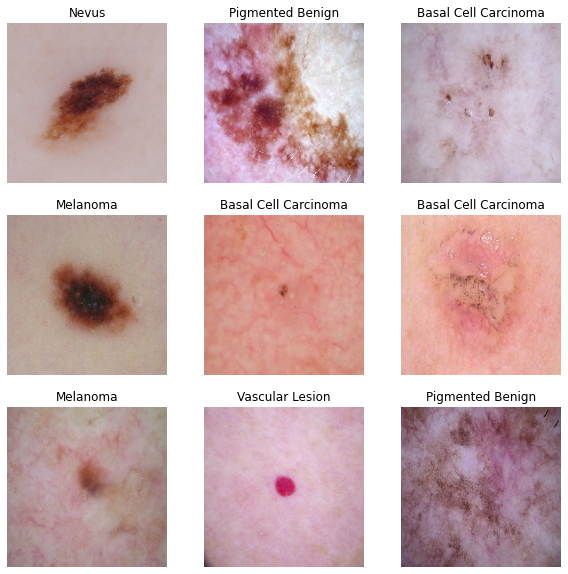

In [13]:
# Display the images
image_batch, label_batch = next(train_data_gen)
show_image(image_batch, label_batch)

The `image_batch` is a tensor of the shape `(32, 180, 180, 3)`. This is a batch of 32 images of shape `180x180x3` (the last dimension refers to color channels RGB). The `label_batch` is a tensor of the shape `(32,)`, these are corresponding labels to the 32 images.

`Dataset.cache()` keeps the images in memory after they're loaded off disk during the first epoch.

`Dataset.prefetch()` overlaps data preprocessing and model execution while training.

In [14]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

### Create the model
#### Todo: Create a CNN model, which can accurately detect 9 classes present in the dataset. Use ```layers.experimental.preprocessing.Rescaling``` to normalize pixel values between (0,1). The RGB channel values are in the `[0, 255]` range. This is not ideal for a neural network. Here, it is good to standardize values to be in the `[0, 1]`

In [15]:
### Your code goes here
model = Sequential([
    layers.experimental.preprocessing.Rescaling(1./255),
    layers.Conv2D(32, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(64, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(128, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(9, activation='softmax')
])

### Compile the model
Choose an appropirate optimiser and loss function for model training 

In [16]:
### Todo, choose an appropirate optimiser and loss function
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [17]:
model.build

<bound method Sequential.build of <tensorflow.python.keras.engine.sequential.Sequential object at 0x7f9d200ff490>>

### Train the model

In [18]:
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
57/57 [==============================] - 951s 3s/step - loss: 2.1707 - accuracy: 0.2150 - val_loss: 1.8253 - val_accuracy: 0.3533
Epoch 2/20
57/57 [==============================] - 4s 66ms/step - loss: 1.6931 - accuracy: 0.4052 - val_loss: 1.5798 - val_accuracy: 0.4622
Epoch 3/20
57/57 [==============================] - 4s 66ms/step - loss: 1.5161 - accuracy: 0.4665 - val_loss: 1.5174 - val_accuracy: 0.4578
Epoch 4/20
57/57 [==============================] - 4s 66ms/step - loss: 1.2985 - accuracy: 0.5468 - val_loss: 1.3895 - val_accuracy: 0.5044
Epoch 5/20
57/57 [==============================] - 4s 65ms/step - loss: 1.1983 - accuracy: 0.5798 - val_loss: 1.4059 - val_accuracy: 0.5089
Epoch 6/20
57/57 [==============================] - 4s 66ms/step - loss: 1.1058 - accuracy: 0.6235 - val_loss: 1.5767 - val_accuracy: 0.4756
Epoch 7/20
57/57 [==============================] - 4s 65ms/step - loss: 0.9835 - accuracy: 0.6530 - val_loss: 1.4416 - val_accuracy: 0.5400
Epoch 8/20
57

In [19]:
# View the summary of all layers
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling (Rescaling)        (None, 180, 180, 3)       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 180, 180, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 90, 90, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 90, 90, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 45, 45, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 45, 45, 128)       73856     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 22, 22, 128)       0

### Visualizing training results

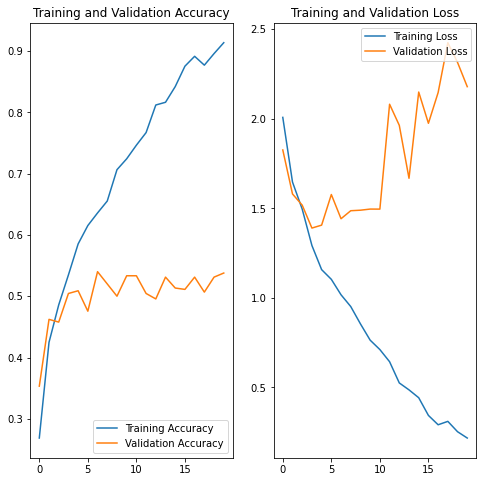

In [20]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### Todo: Write your findings after the model fit, see if there is an evidence of model overfit or underfit

***Note***: ***It is clearly evident from above that the model shows overfitting.***<br>
<br>****There are two observations to justify overfitting:****<br>
****1) After 20 epochs, we could see that validation losses are higher than training losses, and also validation accuracy drastically reduced compared to training accuracy****
 <br> `Training loss: 0.2109 Vs Validation loss: 2.1785`
 <br> `Training accuracy: 0.9159 Vs Validation accuracy: 0.5378`<br>
****2) The above Graph shows difference in the training and validation w.r.t accuracy and losses.****

### Write your findings here

In [21]:
# Todo, after you have analysed the model fit history for presence of underfit or overfit, choose an appropriate data augumentation strategy. 
# Your code goes here
data_augmentation = keras.Sequential(
    [
        layers.experimental.preprocessing.RandomFlip("horizontal"),
        layers.experimental.preprocessing.RandomRotation(0.1),
    ]
)

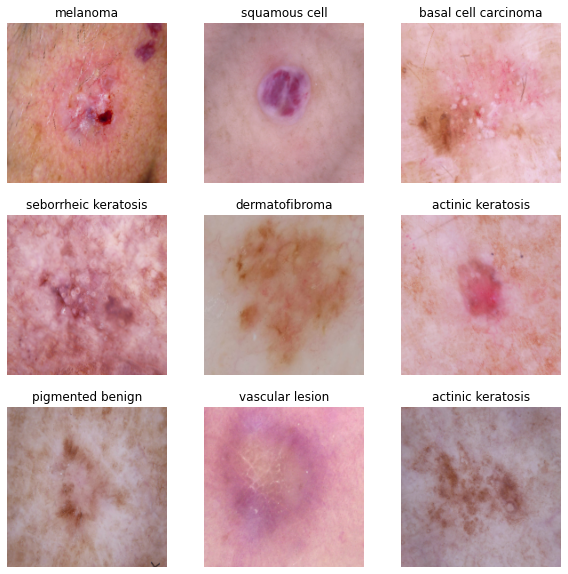

In [22]:
# Todo, visualize how your augmentation strategy works for one instance of training image.
# Your code goes here
for images, labels in train_ds.take(1):
    plt.figure(figsize=(10, 10))
    first_image = images[0]
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        augmented_image = data_augmentation(
            tf.expand_dims(images[i], 0), training=True
        )
        plt.imshow(augmented_image[0].numpy().astype("int32"))
        plt.title(CLASS_NAMES[int(labels[i])])
        plt.axis("off")

### Todo:
### Create the model, compile and train the model


In [23]:
## You can use Dropout layer if there is an evidence of overfitting in your findings

## Your code goes here
model = Sequential([
    layers.experimental.preprocessing.RandomFlip("horizontal"),
    layers.experimental.preprocessing.RandomRotation(0.1),
    layers.experimental.preprocessing.Rescaling(1./255),
    layers.Conv2D(32, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(64, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(128, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Flatten(),
    layers.Dropout(0.15),
    layers.Dense(128, activation='relu'),
    layers.Dense(9, activation='softmax')
])


### Compiling the model

In [24]:
## Your code goes here
model.compile(optimizer='adam',
              # loss='sparse_categorical_crossentropy',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

### Training the model

In [25]:
## Your code goes here, note: train your model for 20 epochs
history =  model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
57/57 [==============================] - 5s 77ms/step - loss: 2.1783 - accuracy: 0.1869 - val_loss: 1.9214 - val_accuracy: 0.3222
Epoch 2/20
57/57 [==============================] - 4s 72ms/step - loss: 1.9293 - accuracy: 0.2775 - val_loss: 1.7266 - val_accuracy: 0.3600
Epoch 3/20
57/57 [==============================] - 4s 72ms/step - loss: 1.7400 - accuracy: 0.4079 - val_loss: 1.5234 - val_accuracy: 0.4333
Epoch 4/20
57/57 [==============================] - 4s 72ms/step - loss: 1.4818 - accuracy: 0.4693 - val_loss: 1.5161 - val_accuracy: 0.4578
Epoch 5/20
57/57 [==============================] - 4s 72ms/step - loss: 1.4180 - accuracy: 0.5072 - val_loss: 1.4627 - val_accuracy: 0.4778
Epoch 6/20
57/57 [==============================] - 4s 73ms/step - loss: 1.4052 - accuracy: 0.5175 - val_loss: 1.5032 - val_accuracy: 0.4667
Epoch 7/20
57/57 [==============================] - 4s 73ms/step - loss: 1.3191 - accuracy: 0.5417 - val_loss: 1.4367 - val_accuracy: 0.4822
Epoch 8/20
57

### Visualizing the results

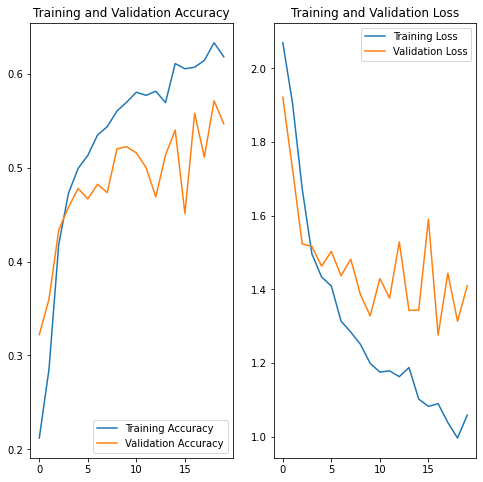

In [26]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### Todo: Write your findings after the model fit, see if there is an evidence of model overfit or underfit. Do you think there is some improvement now as compared to the previous model run?

***Note:***<br> 
****As you can see from above, the current model is not overfit, and it performs better than previous model after adding Augumentation strategy and dropout method. <br><br>Please find the training and validation accuracy:****<br>
****`The training accuracy: 0.6076 & validation accuracy: 0.5467`****<br>
****`The training loss: 1.0574 & validation loss: 1.4096`****
<br><br>****The above graph also shows the evidence of the model not being overfit.****

#### **Todo:** Find the distribution of classes in the training dataset.
#### **Context:** Many times real life datasets can have class imbalance, one class can have proportionately higher number of samples compared to the others. Class imbalance can have a detrimental effect on the final model quality. Hence as a sanity check it becomes important to check what is the distribution of classes in the data.

In [27]:
## Your code goes here.
total_image_count = len(list(data_dir_train.glob('**/*/*.jpg')))
perc_class = {}
for name in class_names:
    perc_class[name] = round((len(list(data_dir_train.glob('{0}/*.jpg'.format(name)))) / total_image_count)*100,2)
df = pd.DataFrame(list(perc_class.items()), columns=['Class', 'Distribution Percentage'])

df

,Class,Distribution Percentage
0,actinic keratosis,5.33
1,basal cell carcinoma,16.70
2,dermatofibroma,4.22
3,melanoma,19.72
4,nevus,15.86
5,pigmented benign,20.52
6,seborrheic keratosis,3.42
7,squamous cell,8.04
8,vascular lesion,6.18


In [28]:
# Get the distribution of data for each class
total_count = 0
data_dict = {}
for name in class_names:
    data_dict[name] = len(list(data_dir_train.glob('{0}/*.jpg'.format(name))))
    total_count += len(list(data_dir_train.glob('{0}/*.jpg'.format(name))))

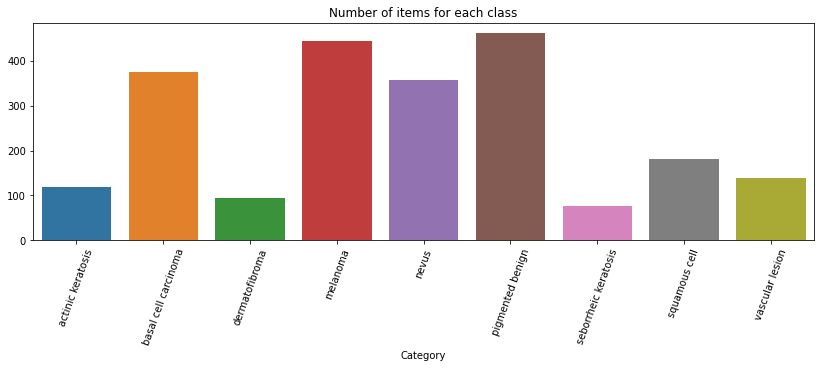

In [29]:
# Plot the distribution of data using bar plot
f, ax = plt.subplots(1,1, figsize=(14,4))
g = sns.barplot(x=list(data_dict.keys()), y = list(data_dict.values()))
g.set_title("Number of items for each class")
g.set_xlabel("Category")
plt.xticks(rotation=70)
plt.show()

#### **Todo:** Write your findings here: 
#### - Which class has the least number of samples?
##### A) The class `"seborrheic keratosis"` has least number (No: 77 items) of samples compared to other classes.
#### - Which classes dominate the data in terms proportionate number of samples?
##### A) The class `"pigmented benign keratosis"` has dominate with large number (No: 462 items)  of samples.


#### **Todo:** Rectify the class imbalance
#### **Context:** You can use a python package known as `Augmentor` (https://augmentor.readthedocs.io/en/master/) to add more samples across all classes so that none of the classes have very few samples.

In [30]:
!pip install Augmentor

To use `Augmentor`, the following general procedure is followed:

1. Instantiate a `Pipeline` object pointing to a directory containing your initial image data set.<br>
2. Define a number of operations to perform on this data set using your `Pipeline` object.<br>
3. Execute these operations by calling the `Pipeline’s` `sample()` method.


In [31]:
path_to_training_dataset="/content/gdrive/MyDrive/app/data/Train/"
import Augmentor
for i in class_names:
    p = Augmentor.Pipeline(path_to_training_dataset + i)
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    p.sample(500) ## We are adding 500 samples per class to make sure that none of the classes are sparse.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7F9CC9980890>:   0%|          | 1/500 [00:00<01:11,  7.00 Samples/s]

Initialised with 120 image(s) found.
Output directory set to /content/gdrive/MyDrive/app/data/Train/actinic keratosis/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7F9CC5E72610>: 100%|██████████| 500/500 [00:21<00:00, 23.55 Samples/s]
Executing Pipeline:   0%|          | 0/500 [00:00<?, ? Samples/s]

Initialised with 376 image(s) found.
Output directory set to /content/gdrive/MyDrive/app/data/Train/basal cell carcinoma/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7F9CC5E1B8D0>: 100%|██████████| 500/500 [00:20<00:00, 24.27 Samples/s]
Executing Pipeline:   0%|          | 0/500 [00:00<?, ? Samples/s]

Initialised with 95 image(s) found.
Output directory set to /content/gdrive/MyDrive/app/data/Train/dermatofibroma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F9CC5E8DFD0>: 100%|██████████| 500/500 [00:21<00:00, 22.86 Samples/s]
Executing Pipeline:   0%|          | 0/500 [00:00<?, ? Samples/s]

Initialised with 444 image(s) found.
Output directory set to /content/gdrive/MyDrive/app/data/Train/melanoma/output.

Processing <PIL.Image.Image image mode=RGB size=3072x2304 at 0x7F9CC9967A10>: 100%|██████████| 500/500 [01:45<00:00,  4.72 Samples/s]
Executing Pipeline:   0%|          | 0/500 [00:00<?, ? Samples/s]

Initialised with 357 image(s) found.
Output directory set to /content/gdrive/MyDrive/app/data/Train/nevus/output.

Processing <PIL.Image.Image image mode=RGB size=767x576 at 0x7F9CC5F43650>: 100%|██████████| 500/500 [01:30<00:00,  5.51 Samples/s]
Executing Pipeline:   0%|          | 0/500 [00:00<?, ? Samples/s]

Initialised with 462 image(s) found.
Output directory set to /content/gdrive/MyDrive/app/data/Train/pigmented benign/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F9CC5E3F490>: 100%|██████████| 500/500 [00:21<00:00, 23.64 Samples/s]
Executing Pipeline:   0%|          | 0/500 [00:00<?, ? Samples/s]

Initialised with 77 image(s) found.
Output directory set to /content/gdrive/MyDrive/app/data/Train/seborrheic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7F9D20352790>: 100%|██████████| 500/500 [00:45<00:00, 11.10 Samples/s]
Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7F9CC5E1B1D0>:   0%|          | 1/500 [00:00<01:26,  5.79 Samples/s]

Initialised with 181 image(s) found.
Output directory set to /content/gdrive/MyDrive/app/data/Train/squamous cell/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F9CC5E720D0>: 100%|██████████| 500/500 [00:20<00:00, 23.86 Samples/s]
Executing Pipeline:   0%|          | 0/500 [00:00<?, ? Samples/s]

Initialised with 139 image(s) found.
Output directory set to /content/gdrive/MyDrive/app/data/Train/vascular lesion/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F9D203A52D0>: 100%|██████████| 500/500 [00:21<00:00, 23.29 Samples/s]


Augmentor has stored the augmented images in the output sub-directory of each of the sub-directories of skin cancer types.. Lets take a look at total count of augmented images.

In [32]:
# Get the total number of samples newly added using Augumentor
image_count_train = len(list(data_dir_train.glob('*/output/*.jpg')))
print(image_count_train)

4500


### Lets see the distribution of augmented data after adding new images to the original training data.

In [33]:
# Get the list of paths that originally had without Augumentor
org_path_list = [x for x in glob(os.path.join(data_dir_train, '*','*.jpg'))]
org_path_list

['/content/gdrive/MyDrive/app/data/Train/seborrheic keratosis/ISIC_0010866.jpg',
 '/content/gdrive/MyDrive/app/data/Train/seborrheic keratosis/ISIC_0010834.jpg',
 '/content/gdrive/MyDrive/app/data/Train/seborrheic keratosis/ISIC_0010898.jpg',
 '/content/gdrive/MyDrive/app/data/Train/seborrheic keratosis/ISIC_0010872.jpg',
 '/content/gdrive/MyDrive/app/data/Train/seborrheic keratosis/ISIC_0010812.jpg',
 '/content/gdrive/MyDrive/app/data/Train/seborrheic keratosis/ISIC_0010852.jpg',
 '/content/gdrive/MyDrive/app/data/Train/seborrheic keratosis/ISIC_0010912.jpg',
 '/content/gdrive/MyDrive/app/data/Train/seborrheic keratosis/ISIC_0010810.jpg',
 '/content/gdrive/MyDrive/app/data/Train/seborrheic keratosis/ISIC_0010883.jpg',
 '/content/gdrive/MyDrive/app/data/Train/seborrheic keratosis/ISIC_0010876.jpg',
 '/content/gdrive/MyDrive/app/data/Train/seborrheic keratosis/ISIC_0010909.jpg',
 '/content/gdrive/MyDrive/app/data/Train/seborrheic keratosis/ISIC_0010900.jpg',
 '/content/gdrive/MyDrive/ap

In [34]:
# Get the class names for each paths of original data
lesion_list_org = [os.path.basename(os.path.dirname(y)) for y in glob(os.path.join(data_dir_train, '*', '*.jpg'))]
print(len(lesion_list_org))

2251


In [35]:
# Add both Path list and class names of original data
dataframe_dict_org = dict(zip(org_path_list, lesion_list_org))

In [36]:
# Create a dataframe using original data
df1 = pd.DataFrame(list(dataframe_dict_org.items()),columns = ['Path','Label'])
len(df1)

2251

In [37]:
# Get the list of paths that new added using Augumentor
path_list = [x for x in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
path_list

['/content/gdrive/MyDrive/app/data/Train/seborrheic keratosis/output/seborrheic keratosis_original_ISIC_0011043.jpg_036f9ee8-5bec-4f1a-9332-c1dc24b30c5f.jpg',
 '/content/gdrive/MyDrive/app/data/Train/seborrheic keratosis/output/seborrheic keratosis_original_ISIC_0010890.jpg_2ebdf021-236d-4e46-8b3c-03722e91b996.jpg',
 '/content/gdrive/MyDrive/app/data/Train/seborrheic keratosis/output/seborrheic keratosis_original_ISIC_0010866.jpg_c6cef880-0fdb-4805-95ad-7e045851b40a.jpg',
 '/content/gdrive/MyDrive/app/data/Train/seborrheic keratosis/output/seborrheic keratosis_original_ISIC_0010852.jpg_dc880666-ec0a-4601-be6f-3189acf57033.jpg',
 '/content/gdrive/MyDrive/app/data/Train/seborrheic keratosis/output/seborrheic keratosis_original_ISIC_0011125.jpg_34046309-79d9-42d6-a0a4-598ae0c0ca33.jpg',
 '/content/gdrive/MyDrive/app/data/Train/seborrheic keratosis/output/seborrheic keratosis_original_ISIC_0010971.jpg_ca6f65ae-504e-4bd2-bfac-875cd9876fc3.jpg',
 '/content/gdrive/MyDrive/app/data/Train/sebor

In [38]:
# Get the class names for each paths of newly added data
lesion_list_new = [os.path.basename(os.path.dirname(os.path.dirname(y))) for y in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
lesion_list_new

['seborrheic keratosis',
 'seborrheic keratosis',
 'seborrheic keratosis',
 'seborrheic keratosis',
 'seborrheic keratosis',
 'seborrheic keratosis',
 'seborrheic keratosis',
 'seborrheic keratosis',
 'seborrheic keratosis',
 'seborrheic keratosis',
 'seborrheic keratosis',
 'seborrheic keratosis',
 'seborrheic keratosis',
 'seborrheic keratosis',
 'seborrheic keratosis',
 'seborrheic keratosis',
 'seborrheic keratosis',
 'seborrheic keratosis',
 'seborrheic keratosis',
 'seborrheic keratosis',
 'seborrheic keratosis',
 'seborrheic keratosis',
 'seborrheic keratosis',
 'seborrheic keratosis',
 'seborrheic keratosis',
 'seborrheic keratosis',
 'seborrheic keratosis',
 'seborrheic keratosis',
 'seborrheic keratosis',
 'seborrheic keratosis',
 'seborrheic keratosis',
 'seborrheic keratosis',
 'seborrheic keratosis',
 'seborrheic keratosis',
 'seborrheic keratosis',
 'seborrheic keratosis',
 'seborrheic keratosis',
 'seborrheic keratosis',
 'seborrheic keratosis',
 'seborrheic keratosis',


In [39]:
# Add both Path list and class names of newly added data
dataframe_dict_new = dict(zip(path_list, lesion_list_new))

In [40]:
# Create a dataframe using newly added data using Augumentor
df2 = pd.DataFrame(list(dataframe_dict_new.items()),columns = ['Path','Label'])
# Merge orginal data with newly added data
new_df = df1.append(df2)

In [41]:
# Show the dsitribution of data after merging
new_df['Label'].value_counts()

pigmented benign        962
melanoma                944
basal cell carcinoma    876
nevus                   857
squamous cell           681
vascular lesion         639
actinic keratosis       620
dermatofibroma          595
seborrheic keratosis    577
Name: Label, dtype: int64

So, now we have added 500 images to all the classes to maintain some class balance. We can add more images as we want to improve training process.

#### **Todo**: Train the model on the data created using Augmentor

In [42]:
batch_size = 32
img_height = 180
img_width = 180

#### **Todo:** Create a training dataset

In [43]:
# data_dir_train="path to directory with training data + data created using augmentor"
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset =  'training',
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6751 files belonging to 9 classes.
Using 5401 files for training.


#### **Todo:** Create a validation dataset

In [44]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = 'validation',
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6751 files belonging to 9 classes.
Using 1350 files for validation.


#### **Todo:** Create your model (make sure to include normalization)

In [45]:
## your code goes here
model = Sequential([

    layers.experimental.preprocessing.RandomFlip("horizontal"),
    layers.experimental.preprocessing.RandomRotation(0.1),
    layers.experimental.preprocessing.Rescaling(1./255),
    layers.Conv2D(32, 3, padding='same', activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D(),

    layers.Conv2D(64, 3, padding='same', activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D(),

    layers.Conv2D(128, 3, padding='same', activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D(),

    layers.Conv2D(128, 3, padding='same', activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D(),

    layers.Conv2D(256, 3, padding='same', activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D(),

    layers.Flatten(),
    layers.Dropout(0.5),
    layers.Dense(512, activation='relu'),
    layers.BatchNormalization(),

    layers.Dense(9, activation='softmax')
])

#### **Todo:** Compile your model (Choose optimizer and loss function appropriately)

In [46]:
## your code goes here
model.compile(optimizer='adam',
              # loss='sparse_categorical_crossentropy',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

#### **Todo:**  Train your model

In [47]:
epochs = 30
## Your code goes here, use 30 epochs.
history =  model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/30
169/169 [==============================] - 65s 362ms/step - loss: 2.0304 - accuracy: 0.3681 - val_loss: 2.8587 - val_accuracy: 0.1148
Epoch 2/30
169/169 [==============================] - 60s 344ms/step - loss: 1.3635 - accuracy: 0.4971 - val_loss: 2.5877 - val_accuracy: 0.2074
Epoch 3/30
169/169 [==============================] - 61s 352ms/step - loss: 1.2742 - accuracy: 0.5272 - val_loss: 1.5271 - val_accuracy: 0.4822
Epoch 4/30
169/169 [==============================] - 59s 340ms/step - loss: 1.1228 - accuracy: 0.5797 - val_loss: 1.6173 - val_accuracy: 0.4726
Epoch 5/30
169/169 [==============================] - 59s 340ms/step - loss: 1.0432 - accuracy: 0.6214 - val_loss: 1.7068 - val_accuracy: 0.4570
Epoch 6/30
169/169 [==============================] - 59s 340ms/step - loss: 0.9447 - accuracy: 0.6506 - val_loss: 1.9286 - val_accuracy: 0.4474
Epoch 7/30
169/169 [==============================] - 59s 339ms/step - loss: 0.8985 - accuracy: 0.6665 - val_loss: 1.8295 - val_ac

#### **Todo:**  Visualize the model results

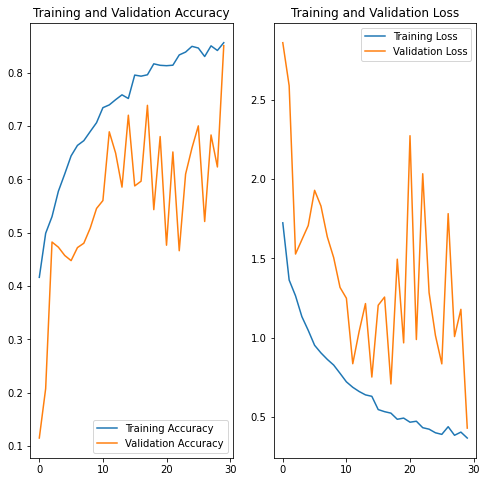

In [48]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### **Todo:**  Analyze your results here. Did you get rid of underfitting/overfitting? Did class rebalance help?



#### Summary:
##### 1. The above model shows that `model is not overfit`. This is because, we were able to` resolve the class rebalance issue by adding more samples of images using Augumentor`.
##### 2. The model is able to predict well by using multiple layers of `Convolution 2D (Upto 256)`.
##### 3. Further, the model is able to generalize well by using `Batch Normalization` in multiple layers.
##### 4. In addition to the above, `dropout (0.5)` has been added to generalize the model.
##### 5. The `training accuracy` has improved with a value of `0.8500` whereas `validation accuracy` is now `0.8504`.
##### 6. The `training loss` is reduced to `0.3789` and `validation loss` is reduced to `0.4304`.
##### 7. The model can be further improved by adding more images.